#%%[markdown]

 # Neural ODE mixed with SINDy framework with mixture of experts
## Summary
 - We have a multistable dynamical systems that we want to learn
 - We only learn on a single attrator
 - Does it learn the other attractor ?

In [ ]:
#%%

import jax

print("Available devices:", jax.devices())

from jax import config
# config.update("jax_debug_nans", True)

import jax.numpy as jnp

import numpy as np
from scipy.integrate import solve_ivp

import equinox as eqx
import diffrax

# import matplotlib.pyplot as plt

from sinode import *

import optax
import time

Available devices: [cuda(id=0)]


In [ ]:
#%%

SEED = 2024
main_key = jax.random.PRNGKey(SEED)

dict_size = 4
mlp_hidden_size = 32
mlp_depth = 4
coeff_threshold = 1e-2
threshold_interval = 1000    ## Threshold the coeffs every this many epochs

## Optimiser hps
init_lr = 1e-4
sched_factor = 0.1

epsilon = 0e2  ## For contrastive loss
eta_inv, eta_cont, eta_spar = 1e-2, 1e-2, 1e-1

## Training hps
print_every = 1000
nb_epochs = 15000
inner_steps_node = 5
inner_steps_coeffs = 5

## Data generation hps
T_horizon = 5
skip = 50

Data shape: (1, 12, 10, 2)


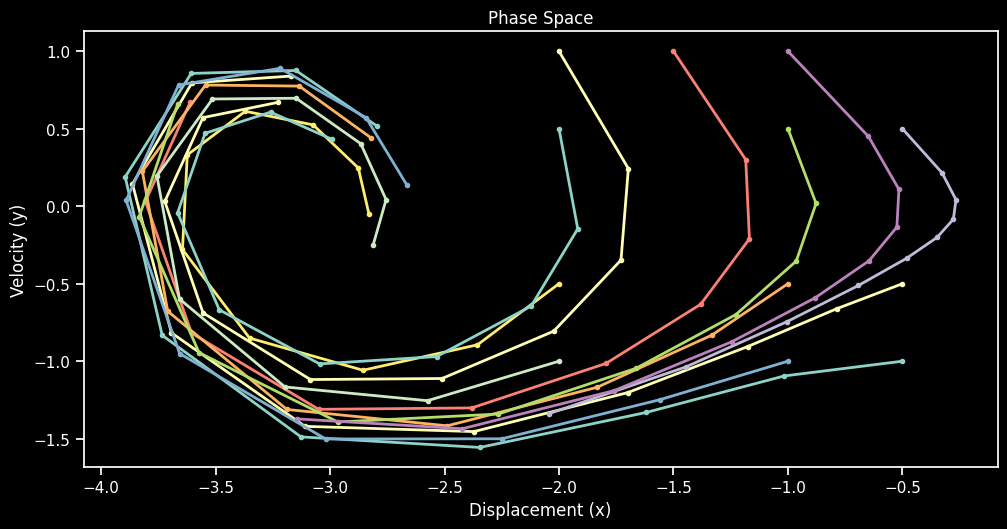

In [ ]:
#%%

# Define the Duffing system
def duffing(t, state, a, b, c):
    x, y = state
    dxdt = y
    dydt = a*y - x*(b + c*x**2)
    return [dxdt, dydt]


# Parameters
a, b, c = -1/2., -1, 1/10.

t_span = (0, T_horizon)
t_eval = np.arange(t_span[0], t_span[1], 0.01)[::skip]

init_conds = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                       [-1.5, 1], 
                    #    [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                    #    [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                    #    [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                    #    [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
train_data = []

for state0 in init_conds:
    sol = solve_ivp(duffing, t_span, state0, args=(a, b, c), t_eval=t_eval)
    train_data.append(sol.y.T)

    ## Plot the phase space
    ax = sbplot(sol.y[0], sol.y[1], ".-", ax=ax, dark_background=True)

ax.set_xlabel('Displacement (x)')
ax.set_ylabel('Velocity (y)')
ax.set_title('Phase Space')


## Save the training data
data = np.stack(train_data)[None, ...]

print("Data shape:", data.shape)

In [ ]:
# %%

class BasisFunction(eqx.Module):
    """ An MLP with a skip connection from input to output, and its inverse via fixed point iteration """
    layers: jnp.ndarray

    def __init__(self, in_size, out_size, hidden_size, depth, activation, key=None):
        keys = jax.random.split(key, num=depth+1)

        self.layers = []

        for i in range(depth):
            if i==0:
                layer = eqx.nn.Linear(in_size, hidden_size, key=keys[i])
            elif i==depth-1:
                layer = eqx.nn.Linear(hidden_size, out_size, key=keys[i])
            else:
                layer = eqx.nn.Linear(hidden_size, hidden_size, key=keys[i])

            self.layers.append(layer)

            if i != depth-1:
                self.layers.append(activation)

    def __call__(self, x):
        """ Returns y such that y = x + MLP(x) """
        y = x
        for layer in self.layers:
            y = layer(y)
        return y

    def inv_call(self, x):
        """ Returns z such that x = z + MLP(z) via fixed point iteration """
        # pass
        # return jnp.broadcast_to(x, (1,))
        return x


## Vectorise across the model
@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def evaluate_funcs_dir(model, x):
    return model(x)

@eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
def evaluate_funcs_inv(model, x):
    return model.inv_call(x)


class VectorField(eqx.Module):
    basis_funcs: BasisFunction

    def __init__(self, data_size, dict_size, mlp_hidden_size, mlp_depth, key=None):
        keys = jax.random.split(key, num=dict_size)

        def make_basis_func(key):
            return BasisFunction(data_size, data_size, mlp_hidden_size, mlp_depth, jax.nn.softplus, key=key)

        self.basis_funcs = eqx.filter_vmap(make_basis_func)(keys)


    def __call__(self, t, x, coeffs):
        """ Forward call of the vector field """
        lambdas, gammas = coeffs
        # assert lambdas.shape == gammas.shape == (self.dict_size, self.data_size)

        y_direct = evaluate_funcs_dir(self.basis_funcs, x)
        y_inverse = evaluate_funcs_inv(self.basis_funcs, x)

        # return jnp.sum(y_direct*lambdas + y_inverse*gammas, axis=0)
        # return jnp.array([y_direct[0,0], y_direct[1,1]])
        return jnp.sum(y_direct*lambdas, axis=0)




class Coefficients(eqx.Module):
    lambdas: jnp.ndarray
    gammas: jnp.ndarray

    def __init__(self, data_size, dict_size, key=None):
        # self.lambdas = jax.random.uniform(key, shape=(dict_size, data_size))
        # self.gammas = jax.random.uniform(key, shape=(dict_size, data_size))

        self.lambdas = jnp.zeros((dict_size, data_size))

        # self.lambdas = self.lambdas.at[0, 0].set(1.)            ## TODO: Remove this
        # self.lambdas = self.lambdas.at[1, 1].set(1.)
        # self.lambdas = self.lambdas.at[2].set(1.)

        self.gammas = jnp.zeros((dict_size, data_size))

    def __call__(self):
        return self.lambdas, self.gammas

class NeuralODE(eqx.Module):
    data_size: int
    dict_size: int
    mlp_hidden_size: int
    mlp_depth: int

    vector_field: VectorField

    def __init__(self, data_size, dict_size, mlp_hidden_size, mlp_depth, key=None):
        self.data_size = data_size
        self.dict_size = dict_size
        self.mlp_hidden_size = mlp_hidden_size
        self.mlp_depth = mlp_depth

        self.vector_field = VectorField(data_size, dict_size, mlp_hidden_size, mlp_depth, key=key)

    def __call__(self, x0s, t_eval, coeffs):

        def integrate(y0):
            sol = diffrax.diffeqsolve(
                    diffrax.ODETerm(self.vector_field),
                    diffrax.Tsit5(),
                    args=(coeffs.lambdas, coeffs.gammas),
                    t0=t_eval[0],
                    t1=t_eval[-1],
                    dt0=1e-3,
                    y0=y0,
                    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
                    saveat=diffrax.SaveAt(ts=t_eval),
                    # adjoint=diffrax.RecursiveCheckpointAdjoint(),
                    max_steps=4096
                )
            return sol.ys

            # sol = RK4(self.vector_field, 
            #           (t_eval[0], t_eval[-1]), 
            #           y0, 
            #           (coeffs.lambdas, coeffs.gammas), 
            #           t_eval=t_eval, 
            #           subdivisions=4)
            # return sol

        return eqx.filter_vmap(integrate)(x0s)

In [ ]:
# %%

model_keys = jax.random.split(main_key, num=2)

model = NeuralODE(data_size=2, dict_size=dict_size, mlp_hidden_size=mlp_hidden_size, mlp_depth=mlp_depth, key=model_keys[0])
coeffs = Coefficients(data_size=2, dict_size=dict_size, key=model_keys[1])

In [ ]:
# %%

def loss_rec(model, coeffs, batch, key):
    """ Reconstruction loss """
    X, t = batch
    X_hat = model(X[:, 0, :], t, coeffs)
    return jnp.mean((X-X_hat)**2)

def loss_inv(model, coeffs, batch, key):
    """ Inverse loss - Assures the inverses are playing their roles """
    X, _ = batch

    @eqx.filter_vmap(in_axes=(None, 0))
    @eqx.filter_vmap(in_axes=(eqx.if_array(0), None))
    def eval_direct_inverse(basis_func, x):
        return basis_func(basis_func.inv_call(x))
    
    X_ = eval_direct_inverse(model.vector_field.basis_funcs, X.reshape(-1, model.data_size))
    X = X.reshape(-1, model.data_size)[:, None, :]

    return jnp.mean((X-X_)**2)

def loss_cont(model, coeffs, batch, key):
    """ Contrastive loss - Makes the weights of the models different """
    X, t = batch

    ## Extract and stack the weights along the last dimension
    basis_funcs = model.vector_field.basis_funcs
    weights = [layer.weight for layer in basis_funcs.layers if isinstance(layer, eqx.nn.Linear)]

    # print([w.shape for w in weights])

    # weights = jnp.stack(weights, axis=-1)

    ## Sample two weights along the first dimention
    ind = jax.random.permutation(key, model.dict_size)[:2]
    # w1, w2 = weights[ind, ...]

    tot_distance = 0.
    for d in range(len(weights)):
        w1, w2 = weights[d][ind[0], ...], weights[d][ind[1], ...]
        tot_distance += jnp.mean((w1-w2)**2)

    return epsilon - tot_distance        ## Maximise the difference between the weights up to epsilon

def loss_sparsity(model, coeffs, batch, key):
    """ Sparsity loss - Makes the coefficients sparse """
    return jnp.mean(jnp.abs(coeffs.lambdas) + jnp.abs(coeffs.gammas))


def loss_fn(model, coeffs, batch, key):

    rec_loss = loss_rec(model, coeffs, batch, key)
    inv_loss = loss_inv(model, coeffs, batch, key)
    cont_loss = loss_cont(model, coeffs, batch, key)
    spar_loss = loss_sparsity(model, coeffs, batch, key)

    # return rec_loss + eta_inv*inv_loss + eta_cont*cont_loss + eta_spar*sparsity_loss
    return rec_loss + eta_cont*cont_loss + eta_spar*spar_loss




@eqx.filter_jit
def train_step_node(model, coeffs, batch, opt_state, key):
    print('\nCompiling function "train_step" for Node ...\n')

    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, coeffs, batch, key)

    updates, opt_state = opt_node.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return model, coeffs, opt_state, loss


@eqx.filter_jit
def train_step_coeffs(model, coeffs, batch, opt_state, key):
    print('\nCompiling function "train_step" for Coeffs...\n')

    new_loss_fn = lambda coeffs, model, batch, key: loss_fn(model, coeffs, batch, key)
    loss, grads = eqx.filter_value_and_grad(new_loss_fn)(coeffs, model, batch, key)

    updates, opt_state = opt_coeffs.update(grads, opt_state)
    coeffs = eqx.apply_updates(coeffs, updates)

    ## Clip coefficients between -threshold and threshold
    # clip = lambda x: jnp.clip(x, -coeff_threshold, coeff_threshold)

    return model, coeffs, opt_state, loss



total_steps = nb_epochs

boundaries_and_scales={int(total_steps*0.25):sched_factor, int(total_steps*0.5):sched_factor, int(total_steps*0.75):sched_factor}

# sched = optax.linear_schedule(init_lr, 0, total_steps, 0.25)
sched_node = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=boundaries_and_scales)
sched_coeffs = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=boundaries_and_scales)

nb_data_points = data.shape[1]
batch_size = nb_data_points

start_time = time.time()


print(f"\n\n=== Beginning Training ... ===")

opt_node = optax.adam(sched_node)
opt_state_node = opt_node.init(eqx.filter(model, eqx.is_array))

opt_coeffs = optax.adam(sched_coeffs)
opt_state_coeffs = opt_coeffs.init(eqx.filter(coeffs, eqx.is_array))


train_key, _ = jax.random.split(main_key)

losses_node = []
losses_coeffs = []

for epoch in range(nb_epochs):

    nb_batches = 0
    loss_sum_node = 0.
    loss_sum_coeffs = 0.

    for i in range(0, nb_data_points, batch_size):
        batch = (data[0,i:i+batch_size,...], t_eval)
    
        for _ in range(inner_steps_node):
            train_key, _ = jax.random.split(train_key)
            model, coeffs, opt_state_node, loss = train_step_node(model, coeffs, batch, opt_state_node, train_key)

        loss_sum_node += loss

        for _ in range(inner_steps_coeffs):
            train_key, _ = jax.random.split(train_key)
            model, coeffs, opt_state_coeffs, loss = train_step_coeffs(model, coeffs, batch, opt_state_coeffs, train_key)
        loss_sum_coeffs += loss

        if epoch%threshold_interval==0:
            ## Jnp where every values above threshold is set to 1, else 0
            clip = lambda x: jnp.where(jnp.abs(x)>=coeff_threshold, x, 0.)
            coeffs = jax.tree.map(clip, coeffs)

        nb_batches += 1

    loss_epoch_node = loss_sum_node/nb_batches
    losses_node.append(loss_epoch_node)

    loss_epoch_coeffs = loss_sum_coeffs/nb_batches
    losses_coeffs.append(loss_epoch_coeffs)

    if epoch%print_every==0 or epoch<=3 or epoch==nb_epochs-1:
        print(f"    Epoch: {epoch:-5d}      LossNode: {loss_epoch_node:.8f}      LossCoeffs: {loss_epoch_coeffs:.8f}", flush=True)

wall_time = time.time() - start_time
time_in_hmsecs = seconds_to_hours(wall_time)
print("\nTotal GD training time: %d hours %d mins %d secs" %time_in_hmsecs)



=== Beginning Training ... ===

Compiling function "train_step" for Node ...


Compiling function "train_step" for Coeffs...

    Epoch:     0      LossNode: 1.83697379      LossCoeffs: 1.83311486
    Epoch:     1      LossNode: 1.83678079      LossCoeffs: 1.83364236
    Epoch:     2      LossNode: 1.83173311      LossCoeffs: 1.82795441
    Epoch:     3      LossNode: 1.82586753      LossCoeffs: 1.82346213
    Epoch:  1000      LossNode: -0.00161627      LossCoeffs: 0.00031809
    Epoch:  2000      LossNode: -0.00033410      LossCoeffs: -0.00259988
    Epoch:  3000      LossNode: -0.00069041      LossCoeffs: -0.00091860
    Epoch:  4000      LossNode: -0.00093618      LossCoeffs: -0.00279354
    Epoch:  5000      LossNode: -0.00052578      LossCoeffs: -0.00074793
    Epoch:  6000      LossNode: -0.00124307      LossCoeffs: -0.00055628
    Epoch:  7000      LossNode: -0.00059630      LossCoeffs: -0.00076749
    Epoch:  8000      LossNode: -0.00127533      LossCoeffs: -0.00060619
    E

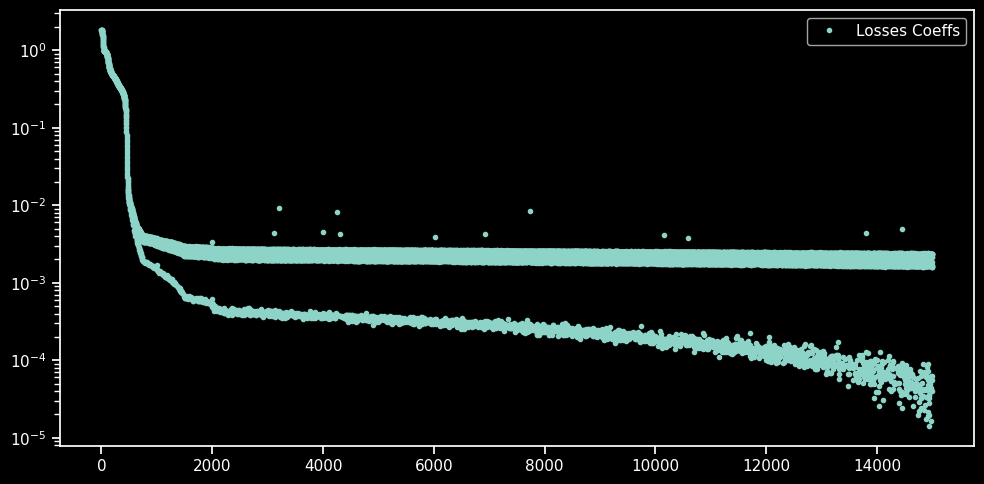

In [ ]:
# %%

## Shift the losses so that they start from 0
losses_node, losses_coeffs = np.array(losses_node), np.array(losses_coeffs)
min_loss = min(np.min(losses_node), np.min(losses_coeffs), 0.)
losses_node += abs(min_loss)
losses_coeffs += abs(min_loss)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax = sbplot(losses_node, x_label='Epoch', y_label='L2', y_scale="log", label='Losses Node', ax=ax, dark_background=True);
ax = sbplot(losses_coeffs[::], ".", y_scale="log", label='Losses Coeffs', ax=ax, dark_background=True);

plt.savefig(f"data/loss.png", dpi=300, bbox_inches='tight')
plt.legend()
# plt.show()

# losses_coeffs

# model = eqx.tree_deserialise_leaves("data/sinode_model.eqx", model)

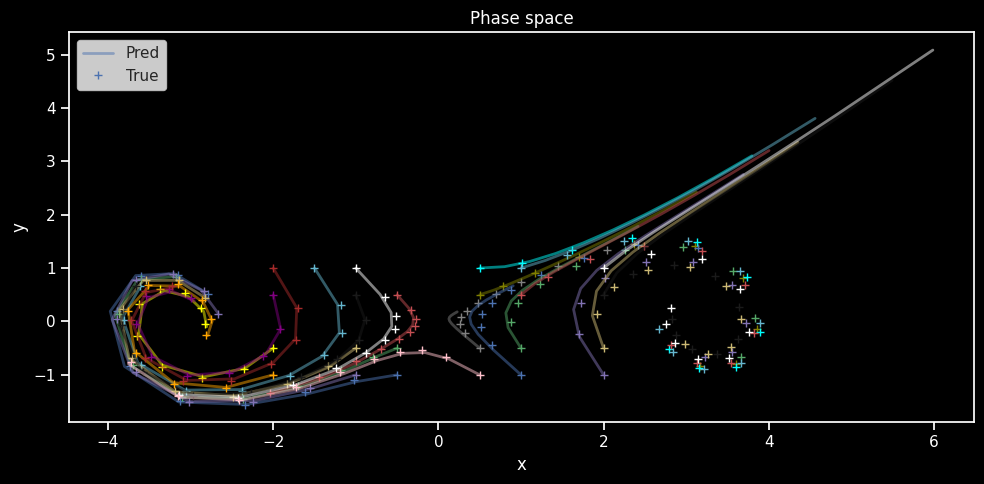

In [ ]:
# %%

## Test the model
def test_model(model, coeffs, batch, key):
    X0, t = batch
    X_hat = model(X0[:, :], t, coeffs)
    return X_hat

init_conds_test = np.array([[-0.5, -1], [-0.5, -0.5], [-0.5, 0.5], 
                       [-1.5, 1], 
                    #    [-0.5, 1], 
                       [-1, -1], [-1, -0.5], [-1, 0.5], [-1, 1], 
                       [-2, -1], [-2, -0.5], [-2, 0.5], [-2, 1],
                       [0.5, -1], [0.5, -0.5], [0.5, 0.5], [0.5, 1],
                       [1, -1], [1, -0.5], [1, 0.5], [1, 1],
                       [2, -1], [2, -0.5], [2, 0.5], [2, 1],
                       ])
test_data = []
for state0 in init_conds_test:
    sol = solve_ivp(duffing, t_span, state0, args=(a, b, c), t_eval=t_eval)
    test_data.append(sol.y.T)
test_data = np.stack(test_data)[None, ...]


X = test_data[0, :, :, :]
# t = np.linspace(t_span[0], t_span[1], T_horizon)
t = t_eval

X_hat = test_model(model, coeffs, (X[:, 0,:], t), train_key)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 'orange', 'yellow', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
colors = colors*10

for i in range(X.shape[0]):
    if i==0:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], "-", x_label='x', y_label='y', label=f'Pred', title=f'Phase space', ax=ax, alpha=0.5, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], "+", lw=1, label=f'True', ax=ax, color=colors[i])
    else:
        sbplot(X_hat[i, :,0], X_hat[i, :,1], "-", x_label='x', y_label='y', ax=ax, alpha=0.5, color=colors[i])
        sbplot(X[i, :,0], X[i, :,1], "+", lw=1, ax=ax, color=colors[i])

plt.savefig(f"data/test_traj.png", dpi=300, bbox_inches='tight')

In [ ]:
#%% 

eqx.tree_serialise_leaves("data/sinode_model_03.eqx", model)

In [ ]:
#%% 

# ## Print coeffs
# print("Coeffs: \n\t  - Lambdas: \n", coeffs.lambdas, "\n\n\t  - Gammas: \n", coeffs.gammas)
print("Coeffs: \n\t  - Lambdas: \n", coeffs.lambdas)

## Print cloeffs lambda with abs > 1e-2
active_coeffs = jnp.where(jnp.abs(coeffs.lambdas)>=coeff_threshold, 1, 0)
print("Active coefficients lambda: \n", active_coeffs)

## Count the number of paramters in the model
params = eqx.filter(model, eqx.is_array)
nb_params = jnp.sum(jnp.array([jnp.prod(jnp.array(p.shape)) for p in jax.tree.flatten(params)[0]]))
print(f"\nNumber of parameters in the model: {nb_params}")

## Print model basis functions
# print("Model basis functions: ", model.vector_field.basis_funcs.layers)
# print("Model basis functions: ", model.vector_field.basis_funcs.layers[2].weight)


## Evaluate the vector field a few points
print("Vector field at [1,1]: \n", evaluate_funcs_dir(model.vector_field.basis_funcs, jnp.array([1., 1.])))
print("Vector field at [2,2]: \n", evaluate_funcs_dir(model.vector_field.basis_funcs, jnp.array([2., 2.])))

Coeffs: 
	  - Lambdas: 
 [[ 1.4029356e-02 -1.7538700e-01]
 [ 5.2734572e-10  1.1907851e-08]
 [ 2.5377975e-08  4.2555179e-02]
 [ 6.2374394e-02 -7.8260444e-02]]
Active coefficients lambda: 
 [[1 1]
 [0 0]
 [0 1]
 [1 1]]

Number of parameters in the model: 9096
Vector field at [1,1]: 
 [[ 4.290251  -1.9260459]
 [-1.3819115  1.2519368]
 [ 3.5212708  6.2218294]
 [ 8.19346    4.68662  ]]
Vector field at [2,2]: 
 [[ 5.0227385 -3.7924361]
 [-1.0392753  1.2405211]
 [ 4.6616354  7.502096 ]
 [11.895489   6.9264617]]


# %% [markdown]

 # Preliminary results
 - Nothing yet !